In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/DataMoods.csv')
df.columns

Index(['name', 'album', 'artist', 'id', 'release_date', 'popularity', 'length',
       'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo', 'key',
       'time_signature', 'mood'],
      dtype='object')

In [4]:
df.shape

(686, 19)

In [5]:
col_features = df.columns[7:-3]
X= MinMaxScaler().fit_transform(df[col_features])
Y = df['mood']
col_features

Index(['danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo'],
      dtype='object')

In [6]:
Y

0          Happy
1            Sad
2            Sad
3          Happy
4      Energetic
         ...    
681         Calm
682          Sad
683          Sad
684          Sad
685         Calm
Name: mood, Length: 686, dtype: object

In [7]:
from keras.utils import np_utils

In [8]:
encoder = LabelEncoder()
encoder.fit(Y)
encodedY = encoder.transform(Y)

Y_one_hot = np_utils.to_categorical(encodedY)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y_one_hot,test_size=0.2,random_state=42)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encodedY}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [9]:
song_moods = {0:'calm', 1:'energetic', 2:'happy', 3:"sad"}

In [10]:
print(X_train.shape, Y_train.shape)

(548, 9) (548, 4)


In [11]:
def base_model():
    model = Sequential()
    model.add(Dense(8,input_dim=9,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model


In [ ]:
# from tensorflow.keras import layers, callbacks

In [ ]:
# early_stopping = callbacks.EarlyStopping(
#   monitor='val_accuracy',
#   min_delta=0.00005,
#   patience=11,
#   verbose=1,
#   restore_best_weights=True
# )

# lr_scheduler = callbacks.ReduceLROnPlateau(
#   monitor='val_accuracy',
#   factor=0.5,
#   patience=7,
#   min_lr=1e-7,
#   verbose=1
# )

# callbacks_list = [early_stopping, lr_scheduler]

In [12]:
model = base_model()
model.summary()

history = model.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test,Y_test),
    verbose=1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 4)                 68        
                                                                 
Total params: 292
Trainable params: 292
Non-trainable params: 0
_________________________________________________________________
Epoch 1/300
18/18 [==============================] - 1s 14ms/step - loss: 1.4541 - accuracy: 0.2318 - val_loss: 1.4017 - val_accuracy: 0.2464
Epoch 2/300
18/18 [==============================] - 0s 5ms/step - loss: 1.3842 - accuracy: 0.3467 - val_loss: 1.3397 - val_accuracy: 0.3551
Epoch 3/300
18/18 [====================

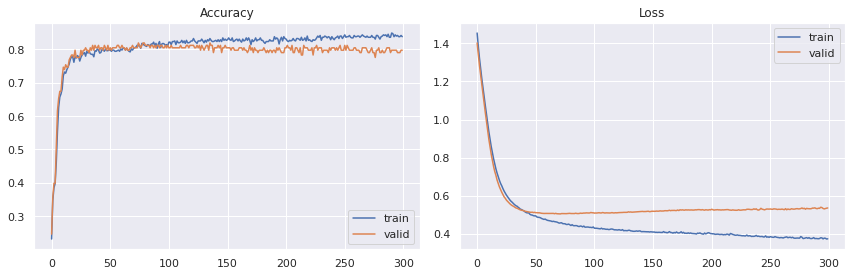

In [13]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('epoch_history_dcnn.png')
plt.show()

In [14]:
new_songs_df = pd.read_csv('/content/drive/MyDrive/Datasets/data.csv') 

features = ['danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'valence', 'loudness', 'speechiness', 'tempo']
pred_X = new_songs_df[features]
pred_X = MinMaxScaler().fit_transform(pred_X)

data_np = np.array(pred_X)

In [15]:
pred_Y = model.predict(data_np)

2/2 [==============================] - 0s 5ms/step


In [16]:
mood = np.array([song_moods[i.argmax()] for i in pred_Y])
mood.shape

(50,)

In [17]:
print(mood)

['happy' 'happy' 'happy' 'happy' 'happy' 'sad' 'happy' 'sad' 'happy'
 'happy' 'happy' 'happy' 'happy' 'happy' 'happy' 'sad' 'happy' 'happy'
 'sad' 'energetic' 'happy' 'happy' 'happy' 'happy' 'sad' 'happy' 'happy'
 'energetic' 'energetic' 'sad' 'happy' 'happy' 'happy' 'happy' 'energetic'
 'happy' 'happy' 'happy' 'happy' 'happy' 'happy' 'happy' 'energetic'
 'happy' 'happy' 'happy' 'sad' 'happy' 'happy' 'happy']


In [19]:
new_songs_df['mood'] = mood
new_songs_df.shape

(50, 20)

In [21]:
new_songs_df.to_csv('/content/drive/MyDrive/Datasets/datawithmood.csv')

In [22]:
model.save("/content/drive/MyDrive/Datasets/songmodel.h5")